In [47]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [48]:
train_data=pl.read_csv("train_featureEngineered.csv")
test_data=pl.read_csv("test_featureEngineered.csv")
train_data.shape,test_data.shape

((150, 12), (52, 12))

In [49]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

# Lasso regression

Mean absolute Error: 1421.1947895434735
R-squared on holdout set: 0.8809645227188405
Adjusted R-squared on holdout set: 0.8519314794795333


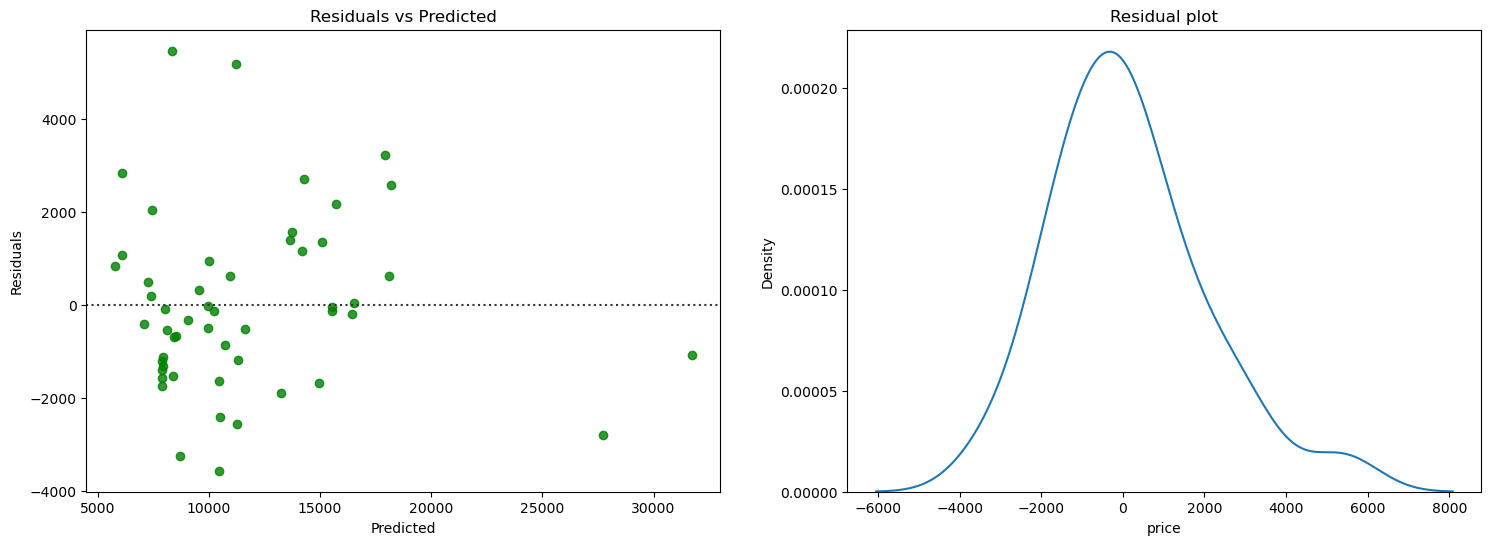

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import cross_val_predict,cross_val_score,RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
from skopt import BayesSearchCV
import statsmodels.api as sm

imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")

lasso_pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("regressor",Lasso())
])

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

rkf=RepeatedKFold(n_splits=10,random_state=42)
param_space = {
    'regressor__alpha': (1e-3, 1e3, 'log-uniform'),
}
bayes_search = BayesSearchCV(estimator=lasso_pipe, search_spaces=param_space, n_iter=20, cv=rkf, n_jobs=-1, random_state=42)
bayes_search.fit(X_train, y_train)

best_alpha = bayes_search.best_params_['regressor__alpha']

lasso_pipe.set_params(regressor__alpha=best_alpha)
lasso_pipe.fit(X_train, y_train)

cv_scores = cross_val_score(lasso_pipe, X_train, y_train, cv=rkf,n_jobs=-1)

sc=StandardScaler()
predictions = cross_val_predict(lasso_pipe, X_test, y_test,groups=X_test["aspiration"])
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')
# Plotting residuals
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(18, 6))
sns.residplot(x=predictions, y=residuals, color='g', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals, ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# Ridge regression

Mean absolute Error: 1421.1947895434735
R-squared on holdout set: 0.8809645227188405
Adjusted R-squared on holdout set: 0.8519314794795333


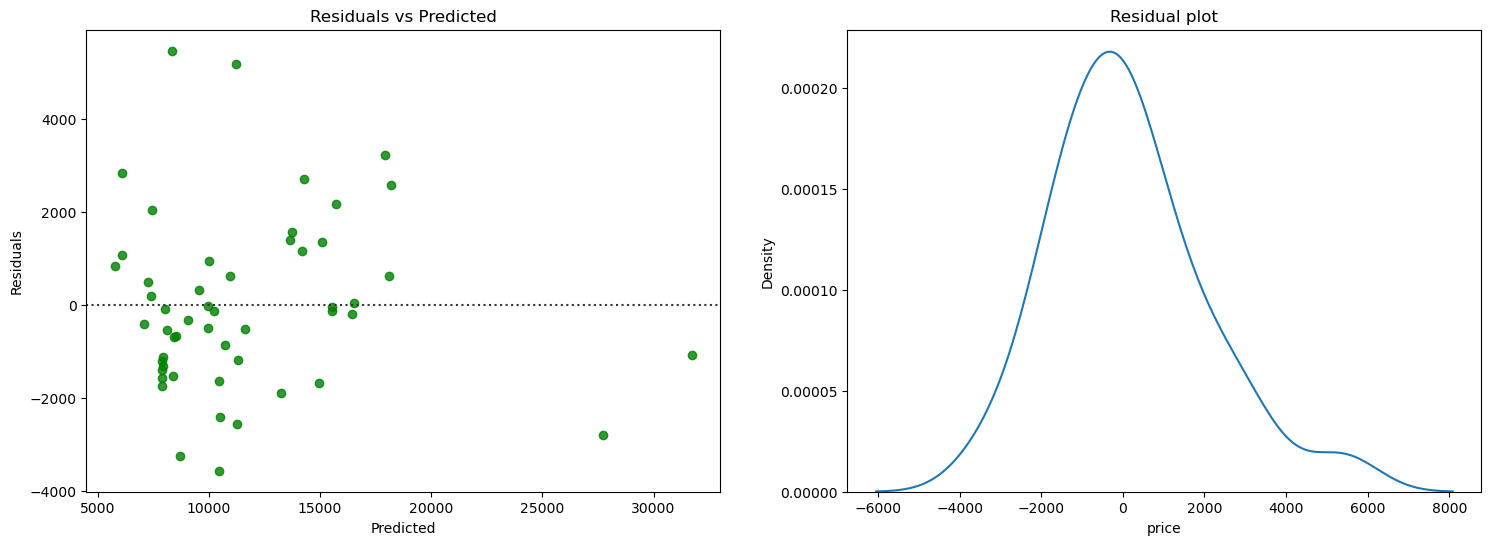

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import cross_val_predict,cross_val_score,RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
from skopt import BayesSearchCV
import statsmodels.api as sm

imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")

ridge_pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("regressor",Ridge())
])

rkf=RepeatedKFold(n_splits=10,random_state=42)
param_space = {
    'regressor__alpha': (1e-3, 1e3, 'log-uniform'),
}
bayes_search = BayesSearchCV(estimator=ridge_pipe, search_spaces=param_space, n_iter=20, cv=rkf, n_jobs=-1, random_state=42)
bayes_search.fit(X_train, y_train)

best_alpha = bayes_search.best_params_['regressor__alpha']

ridge_pipe.set_params(regressor__alpha=best_alpha)
ridge_pipe.fit(X_train, y_train)

cv_scores = cross_val_score(ridge_pipe, X_train, y_train, cv=rkf)

sc=StandardScaler()
predictions = cross_val_predict(lasso_pipe, X_test, y_test,groups=X_test["aspiration"])
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')
# Plotting residuals
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(18, 6))
sns.residplot(x=predictions, y=residuals, color='g', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals, ax=ax2)
ax2.set_title("Residual plot")
plt.show()

# ElasticNet Regression

Mean Test Score: 0.8473084221756353
Standard Deviation of Test Scores: 0.11115731035744963
Mean absolute Error: 1322.7235862806915
R-squared on holdout set: 0.9060968427340661
Adjusted R-squared on holdout set: 0.883193633644814


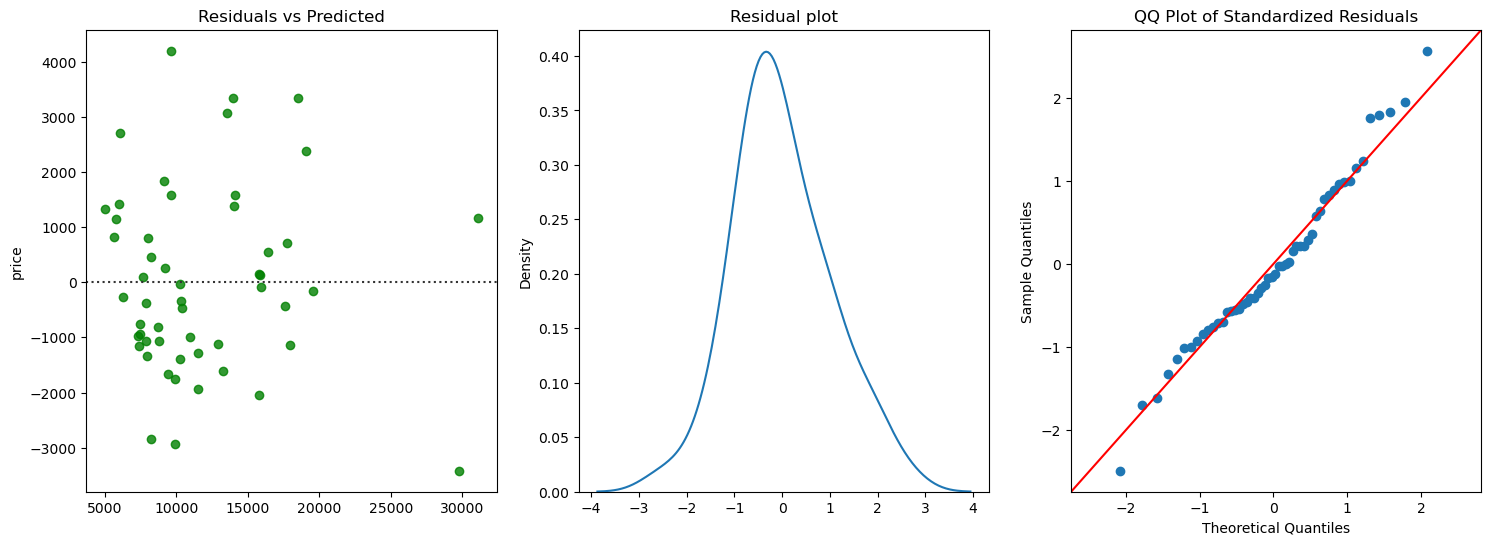

In [52]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_validate
from skopt import BayesSearchCV

elastic_pipe = Pipeline([
    ('imputer', imputer),
    ('regressor', ElasticNet())
])
param_space = {
    'regressor__alpha': (1e-3, 1e3, 'log-uniform'),
    'regressor__l1_ratio': (0.1, 0.9),
    'regressor__fit_intercept': (True,False),
}

rkf=RepeatedKFold(n_splits=10,random_state=42)
bayes_search = BayesSearchCV(estimator=elastic_pipe, search_spaces=param_space, n_iter=20, cv=rkf, n_jobs=-1, random_state=42)
bayes_search.fit(X_train, y_train)

best_alpha = bayes_search.best_params_['regressor__alpha']
best_l1_ratio = bayes_search.best_params_['regressor__l1_ratio']
best_fit_intercept = bayes_search.best_params_['regressor__fit_intercept']

elastic_pipe.set_params(regressor__alpha=best_alpha)
elastic_pipe.set_params(regressor__l1_ratio=best_l1_ratio)
elastic_pipe.set_params(regressor__fit_intercept=best_fit_intercept)
elastic_pipe.fit(X_train, y_train)
cv_results = cross_validate(elastic_pipe, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1)
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(elastic_pipe, X_test, y_test,n_jobs=-1)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3] = plt.subplots(ncols=3,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
plt.show()

# Elastic net regressor work better

In [53]:
from sklearn.model_selection import RepeatedKFold

# Define a list of desired split values (e.g., 3, 5, 10)
split_values = [3, 5, 10]

for n_splits in split_values:
  rkf = RepeatedKFold(n_splits=n_splits, random_state=42)

  bayes_search = BayesSearchCV(estimator=elastic_pipe, search_spaces=param_space, n_iter=20, cv=rkf, n_jobs=-1, random_state=42)
  bayes_search.fit(X_train, y_train)

  best_alpha = bayes_search.best_params_['regressor__alpha']
  best_l1_ratio = bayes_search.best_params_['regressor__l1_ratio']
  best_fit_intercept = bayes_search.best_params_['regressor__fit_intercept']

  elastic_pipe.set_params(regressor__alpha=best_alpha)
  elastic_pipe.set_params(regressor__l1_ratio=best_l1_ratio)
  elastic_pipe.set_params(regressor__fit_intercept=best_fit_intercept)
  elastic_pipe.fit(X_train, y_train)
  cv_results = cross_validate(elastic_pipe, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1)


  sc=StandardScaler()
  predictions = cross_val_predict(elastic_pipe, X_test, y_test,n_jobs=-1)
  residuals = y_test - predictions
  std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
  std_residuals = std_residuals.flatten()
  mae = mean_absolute_error(y_test, predictions)
  r2 = r2_score(y_true=y_test,y_pred= predictions)
  n,p = X_test.shape
  adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)



  # Print results for each n_splits value
  print(f"\n Results for {n_splits} splits:")
  print(f'Mean Test Score: {cv_results["test_score"].mean()}')
  print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')



 Results for 3 splits:
Mean Test Score: 0.8869838028756776
Standard Deviation of Test Scores: 0.030793652236568075

 Results for 5 splits:
Mean Test Score: 0.8846354763901323
Standard Deviation of Test Scores: 0.05057554486734314

 Results for 10 splits:
Mean Test Score: 0.8473084221756353
Standard Deviation of Test Scores: 0.11115731035744963


Mean Test Score: 0.8869838028756776
Standard Deviation of Test Scores: 0.030793652236568075
Mean absolute Error: 1268.3572966281874
R-squared on holdout set: 0.9085736754233583
Adjusted R-squared on holdout set: 0.8862745718680799


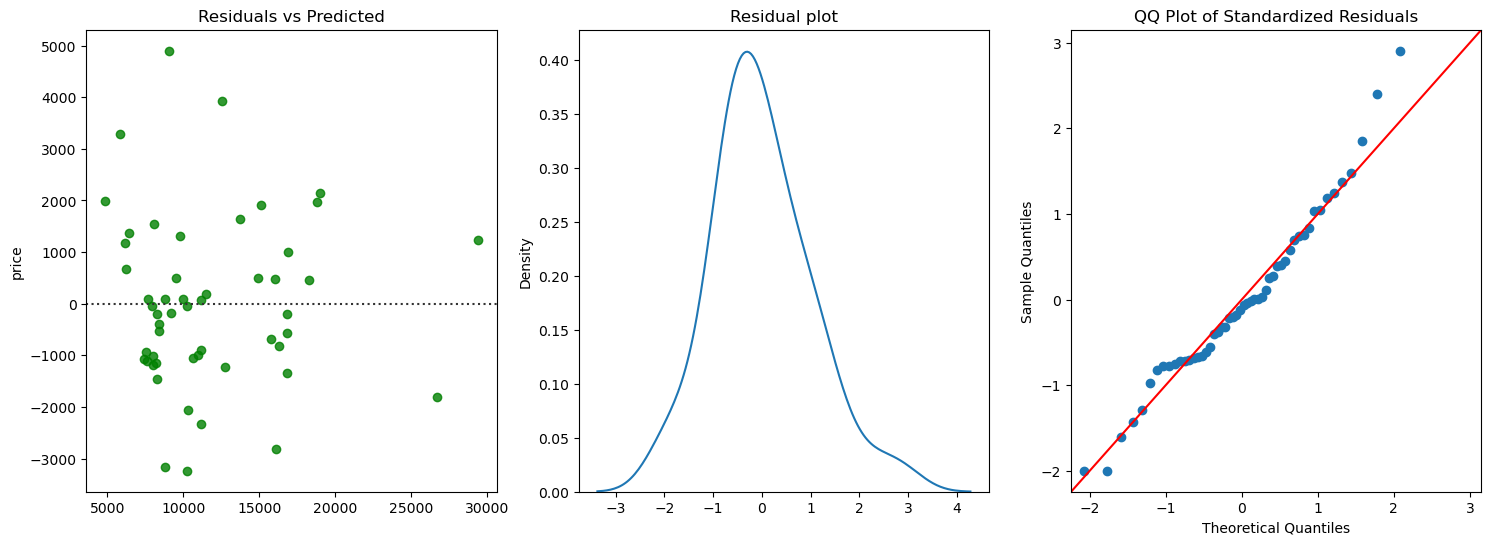

In [57]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_validate
from skopt import BayesSearchCV

elastic_pipe = Pipeline([
    ('imputer', imputer),
    ('regressor', ElasticNet())
])
param_space = {
    'regressor__alpha': (1e-3, 1e3, 'log-uniform'),
    'regressor__l1_ratio': (0.1, 0.9),
    'regressor__fit_intercept': (True,False),
}

rkf=RepeatedKFold(n_splits=3,random_state=42)
bayes_search = BayesSearchCV(estimator=elastic_pipe, search_spaces=param_space, n_iter=20, cv=rkf, n_jobs=-1, random_state=42)
bayes_search.fit(X_train, y_train)

best_alpha = bayes_search.best_params_['regressor__alpha']
best_l1_ratio = bayes_search.best_params_['regressor__l1_ratio']
best_fit_intercept = bayes_search.best_params_['regressor__fit_intercept']

elastic_pipe.set_params(regressor__alpha=best_alpha)
elastic_pipe.set_params(regressor__l1_ratio=best_l1_ratio)
elastic_pipe.set_params(regressor__fit_intercept=best_fit_intercept)
elastic_pipe.fit(X_train, y_train)
cv_results = cross_validate(elastic_pipe, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1)
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(elastic_pipe, X_test, y_test,n_jobs=-1)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3] = plt.subplots(ncols=3,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
plt.show()

In [56]:
bayes_search.best_estimator_

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                min_frequency=9),
                                                  ['aspiration', 'carbody',
                                                   'enginetype',
                                                   'fuelsystem']),
                                                 ('num', StandardScaler(),
                                                  ['carclass', 'brandavg',
                                                   'carspace', 'averagempg',
                                                   'performancebalance',
                                                   'enginedisplacement'])])),
                ('regressor',
                 ElasticNet(alpha=0.18963880779854334, l1_ratio=0.1))])

In [55]:
def avg_elastic(X_train,X_test, y_train,y_test, num_iterations=30, num_bootstrap=1000):
    elastic_errors = []
    elastic_scores = []
    elastic_adj_scores=[]
    for i in range(num_iterations):
        rkf=RepeatedKFold(n_splits=3,random_state=42+i)
        bayes_search = BayesSearchCV(estimator=elastic_pipe, search_spaces=param_space, n_iter=20, cv=rkf, n_jobs=-1, random_state=42)
        bayes_search.fit(X_train, y_train)

        best_alpha = bayes_search.best_params_['regressor__alpha']
        best_l1_ratio = bayes_search.best_params_['regressor__l1_ratio']
        best_fit_intercept = bayes_search.best_params_['regressor__fit_intercept']

        elastic_pipe.set_params(regressor__alpha=best_alpha)
        elastic_pipe.set_params(regressor__l1_ratio=best_l1_ratio)
        elastic_pipe.set_params(regressor__fit_intercept=best_fit_intercept)
        elastic_pipe.fit(X_train, y_train)
        
        predictions = cross_val_predict(elastic_pipe, X_test, y_test,n_jobs=-1)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_true=y_test,y_pred= predictions)
        n,p = X_test.shape
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        
        elastic_errors.append(mae)
        elastic_scores.append(r2)
        elastic_adj_scores.append(adjusted_r2)
        
    # Convert lists to numpy arrays for easier manipulation
    elastic_adj_scores = np.array(elastic_adj_scores)
    elastic_scores = np.array(elastic_scores)
    
    # Calculate the mean and median errors and scores
    mean_error = np.mean(elastic_errors)
    median_error = np.median(elastic_errors)
    mean_r2 = np.mean(elastic_scores)
    median_r2 = np.median(elastic_scores)
    mean_adj_r2 = np.mean(elastic_adj_scores)
    median_adj_r2 = np.median(elastic_adj_scores)
    
    # Bootstrap for confidence intervals
    bootstrapped_adj_r2 = []
    n = len(elastic_adj_scores)
    for _ in range(num_bootstrap):
        sample_indices = np.random.choice(np.arange(n), size=n, replace=True)
        sample_adj_r2 = elastic_adj_scores[sample_indices]
        bootstrapped_adj_r2.append(np.mean(sample_adj_r2))
    
    lower_bound_adj_r2 = np.percentile(bootstrapped_adj_r2, 2.5)
    upper_bound_adj_r2 = np.percentile(bootstrapped_adj_r2, 97.5)
    sns.histplot(bootstrapped_adj_r2)
    plt.title("Bootstrapped Elastic Adj R2 scores")
    plt.axvline(lower_bound_adj_r2)
    plt.axvline(upper_bound_adj_r2)
    plt.show()
    return elastic_scores, mean_error, median_error, mean_r2, median_r2,mean_adj_r2,median_adj_r2, lower_bound_adj_r2, upper_bound_adj_r2

# Assuming X and y are defined
elastic_scores, elastic_mae_mean, elastic_mae_median, elastic_r2_mean, elastic_r2_median,elastic_mean_adj_r2,elastic_median_adj_r2, lower_bound_adj_r2, upper_bound_adj_r2 = avg_elastic(X_train,X_test, y_train,y_test)

print(f'Mean Absolute Elasticnet Error: {elastic_mae_mean}')
print(f'Median Absolute Elasticnet Error: {elastic_mae_median}')
print(f'Avg Mean Elasticnet R-squared: {elastic_r2_mean}')
print(f'Avg Median Elasticnet R-squared: {elastic_r2_median}')
print(f'Avg Mean Adjusted Elasticnet R-squared: {elastic_mean_adj_r2}')
print(f'Avg Median Adjusted Elasticnet R-squared: {elastic_median_adj_r2}')
print(f'95% Confidence Interval for adj R-squared: ({lower_bound_adj_r2}, {upper_bound_adj_r2})')

KeyboardInterrupt: 